In [7]:
# This method reads a CSV file containing questions and their corresponding chunk IDs.
# It returns a list of dictionaries where each dictionary contains the chunk ID as the key and the question as the value.

import csv

def get_queries_from_csv(csv_file):
    queries_chunk_map = []

    # Open and read the CSV file
    with open(csv_file, mode='r', newline='', encoding='utf-8') as file:
        reader = csv.DictReader(file) # DictReader reads the CSV file into a dictionary format, where the keys are the column names and the values are the corresponding data in each row.

        # Iterate over each row in the CSV file
        for row in reader:
            chunk_id = row['Chunk']  #Getting what coresponds to the column 'Chunk' of the dictionary
            query= row['Question']   #Getting what coresponds to the column 'Question' of the dictionary

            # Create a dictionary with chunk_id as key and question as value and appends it to the list
            queries_chunk_map.append({chunk_id: query})

    return queries_chunk_map

In [8]:

import pandas as pd
def get_CSVcolumn(csv_file,column_name):


    # Read the CSV file
    df = pd.read_csv(csv_file)

    # Extract the questions into a list
    column_list = df[column_name].tolist()

    # Print the list (optional)
    print(column_list)
    
    # Return the list
    return column_list

# Example usage:
csv_file = '/mount/arbeitsdaten/studenten4/ashousaa/chunks.csv'  # replace with your actual file path
column_name = 'chunk_text'  # replace with the actual column name you want to extract
result = get_CSVcolumn(csv_file, column_name)
print(result)

['English Travel Reimbursement Law Revised Version of the State Travel Expense Act \nPreliminary Page A. Objective The previous travel expense regulations are outdated and require \nupdating and legal simplification to facilitate the conduct and administrative processing of official \ntravel. In addition, with regard to mobility behavior, the requirements of climate protection shall \nbe taken into account (the exemplary function of the state administration pursuant to §  of the \nBaden-Württemberg Climate Protection Act).', 'Revised Version of the State Travel Expense Act \nPreliminary Page B. Essential Content A revision of the State Travel Expense Act resulting in a \nmodern regulatory framework. The focal points are: . A new regulation for travel costs and \nmileage allowance. . . . . Adjustment of the reduction of the per diem allowance in the case of \ncomplimentary meals in line with tax law provisions, thereby eliminating the need to tax parts of \nthe per diem. The provisions 

In [9]:
# from sentence_transformers import SentenceTransformer
# import torch

# def get_top_matching_chunks(k,query):

#     # Load a pretrained Sentence Transformer model
#     model = SentenceTransformer("all-MiniLM-L6-v2")

#     # Get all chunks from the CSV file
#     chunks = get_CSVcolumn("chunks.csv","chunk_text")

#     # Encode all chunks
#     chunk_embeddings = model.encode(chunks, convert_to_tensor=True)
#     print(chunk_embeddings.shape)

#     # Encode the query
#     query_embedding = model.encode(query, convert_to_tensor=True)
#     print(query_embedding.shape)

#     #  Calculate the embedding similarities
#     cos = torch.nn.CosineSimilarity(dim=1)
#     similarities = cos(chunk_embeddings, query_embedding)
#     print(similarities.shape)


#     # Display top N most similar chunks
#     top_n = k
#     top_indices = torch.topk(similarities, k=top_n,dim=0).indices
#     return top_indices

# #Example usage:
# query = "What is the capital of France?"
# k = 5
# top_indices = get_top_matching_chunks(k, query)
# print("Top matching chunks indices:", top_indices)

from sentence_transformers import SentenceTransformer
import torch
import pandas as pd

def get_top_matching_chunks(query, k):
    # Load the model only once (move it outside this function if calling often)
    model = SentenceTransformer("all-MiniLM-L6-v2") 
    # model = SentenceTransformer("all-mpnet-base-v2") # around 7% better 

    # Load CSV with both chunk_id and chunk_text
    df = pd.read_csv("chunks.csv")  # assumes columns: chunk_id, chunk_text

    # Get lists
    chunk_ids = df["chunk_id"].tolist()
    chunk_texts = df["chunk_text"].tolist()

    # Encode chunks and query
    chunk_embeddings = model.encode(chunk_texts, convert_to_tensor=True)
    query_embedding = model.encode(query, convert_to_tensor=True)

    # Compute cosine similarity
    cos = torch.nn.CosineSimilarity(dim=1)
    similarities = cos(chunk_embeddings, query_embedding)

    # Get top-k indices
    top_indices = torch.topk(similarities, k=k).indices.tolist()


    # Map indices back to chunk_ids
    top_chunk_ids = [chunk_ids[i] for i in top_indices]

    return top_chunk_ids

# # Example usage
# query = "What is the deadline for submitting a travel expense reimbursement application?"
# k = 5
# top_chunk_ids = get_top_matching_chunks(query, k)
# print("Top matching chunk IDs:", top_chunk_ids)


In [10]:
import unicodedata
import re

def normalize_string(s):
    # Step 1: Convert to lowercase
    s = s.lower()
    
    # Step 2: Strip leading/trailing whitespace
    s = s.strip()
    
    # Step 3: Normalize Unicode characters (e.g., accented characters)
    s = unicodedata.normalize('NFKD', s)  # Normalize to decomposed form
    
    # Step 4: Remove non-printable characters (e.g., invisible characters)
    s = re.sub(r'[^\x20-\x7E]', '', s)  # Keep only printable characters
    
    return s


Query: 1 What is an official trip?, Correct Chunk ID: chunk_8
Top 1 chunk IDs: ['chunk_8']
Query: 2 Could you please define what constitutes an “official trip”?, Correct Chunk ID: chunk_8
Top 1 chunk IDs: ['chunk_8']
Query: 3 Does the approval for official travel have to be submitted as a physical document?, Correct Chunk ID: chunk_8
Top 1 chunk IDs: ['chunk_8']
Query: 4 Is a hard copy required for travel authorization?, Correct Chunk ID: chunk_8
Top 1 chunk IDs: ['chunk_10']
Query: 5 If there is a less expensive method for me to do my job, my official trip can get cancelled?, Correct Chunk ID: Chunk_8
Top 1 chunk IDs: ['chunk_34']
Query: 6 Could an approved work trip be rescinded if a cheaper way to complete the necessary tasks becomes available?, Correct Chunk ID: Chunk_8
Top 1 chunk IDs: ['chunk_8']
Query: 7 What is an official errand?, Correct Chunk ID: Chunk_9
Top 1 chunk IDs: ['chunk_9']
Query: 8 Could you explain what constitutes a legitimate, authorized task or duty?, Correct C

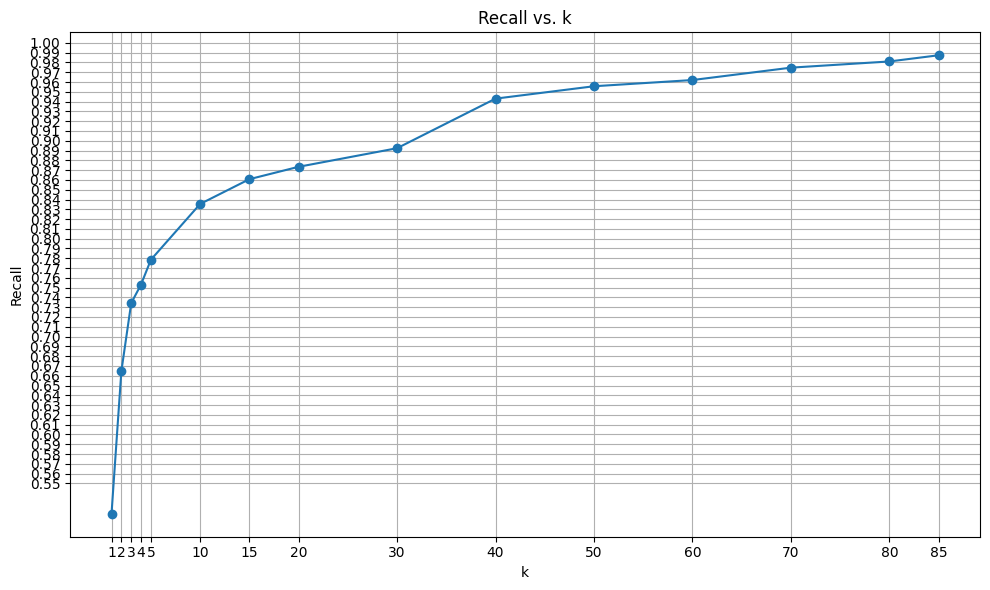

In [11]:
import matplotlib.pyplot as plt
import numpy as np

k_list = [1, 2, 3, 4, 5,10,15,20,30,40,50,60,70,80,85]
recall_dict = {}

# Get the questions and their corresponding chunk IDs
csv_file = '/mount/arbeitsdaten/studenten4/ashousaa/modified_final_test_set.csv'  
query_dict_list = get_queries_from_csv(csv_file)

for k in k_list:
    recall_list = []
    query_number= 1

    for query_dict in query_dict_list:
       
        chunk_id, query = list(query_dict.items())[0] # Turning the dictionary into a list of tuples and unpacking the first (and only) tuple into chunk_id and query tuple
       
        
        print(f"Query: {query_number} {query}, Correct Chunk ID: {chunk_id}")
        query_number += 1  # Increment the query number for the next iteration

        answer_set = get_top_matching_chunks(query,k)
        print(f"Top {k} chunk IDs: {answer_set}")
 
        normalized_chunk_id = normalize_string(chunk_id)
        normalized_answer_set = [normalize_string(a) for a in answer_set]
        recall_list.append(normalized_chunk_id in normalized_answer_set)
        
        
    print(f"For k = {k} The recall list is {recall_list}")

    recall_dict[k] = sum(recall_list) / len(recall_list)


# Plot the recall
plt.figure(figsize=(10, 6)) # Adjust figure size as needed
plt.plot(recall_dict.keys(), recall_dict.values(), marker='o', linestyle='-') # Plot recall values over steps, marking each point with circles and connecting them with lines.
plt.xlabel('k')
plt.ylabel('Recall')
plt.title('Recall vs. k')
plt.grid(True)
plt.xticks(k_list) # Ensure all k values are displayed on the x-axis
plt.yticks(np.arange(0.55, 1.01, 0.01))  # Adjust range and step size as needed
plt.tight_layout()
plt.show()

